In [ ]:
import scipy.io as io
import matplotlib.pyplot as plt
from matplotlib import animation
import numpy as np
import numpy as np
from itertools import product
import os
from ExtendedTSSRP import ExtendedTSSRP
from TSSRP import TSSRP
from MSSRP import MSSRP
# from adaptCUSUM import AdaptCUSUM
from spc import spc
import time
import pickle

data = io.loadmat('data/temperature.mat')
X_org = data['mMov0']
X = data['mMov1']
X = np.rollaxis(X,2,0)
X_org = np.rollaxis(X_org,2,0)
X.shape
nt,nx,ny = X.shape


In [2]:
nt,nx,ny 

(336, 71, 121)

In [3]:
np.mean(X[:50]*14),np.std(X[:50]*14),np.max(X[:50]*14)

(4.8919133520944165, 0.9873259878763835, 14.0)

In [4]:
X = X*14

In [ ]:
fig,ax = plt.subplots(111)
isample = 0
ims = []
for t in range(nt):
    im = ax[0].imshow(X[t],cmap=plt.get_cmap('hot'))
    ax[0].set_title(str(t))
    ims.append([im])
ani = animation.ArtistAnimation(fig, ims, interval=50,blit=True,repeat_delay=1000)
ani.save('3D_original.mp4')

In [120]:
from IPython.display import Video
Video("3D_original.mp4")

# Find the printing regions from the dataset 

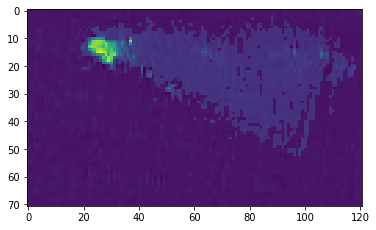

In [5]:
printingregion = np.sum(X_org,0)>30
defectregion = X[-100]
plt.imshow(printingregion+defectregion)

# Find the failure mode $M$ for that overlaps with the printing regions

In [6]:
from Bspline import bsplineBasis
kx = 7
ky = 10
degree = 1 # Overlap region? (Size of B-spline basis) 
Bx = bsplineBasis(nx,kx-degree+1,degree)
By = bsplineBasis(ny,ky-degree+1,degree)
Mall = np.kron(Bx,By)



In [7]:
Mall.shape

(8591, 70)

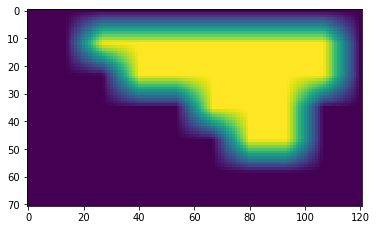

In [8]:
ii = []
MMregion = 0
for i in np.arange(Mall.shape[1]):
    mM = Mall[:,i].reshape(nx,ny)
    mMregion = mM > 0.5
    res = np.logical_and(mMregion,printingregion)
    if np.sum(res[:]) > 20:
        ii.append(i) 
        MMregion = MMregion + mM
M = Mall[:,ii]
plt.imshow(MMregion)

In [9]:
np.max(M)

0.9999999999999999

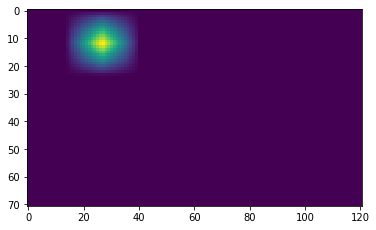

In [10]:
plt.imshow(M[:,0].reshape(nx,ny))

In [33]:
p = nx*ny # Number of dimensions
c = 14 # Target meanshift is c * M
nsensors = 100 # Number of selected sensors
Ks = 10  #Select Top Ks control chart
k = M.shape[1]
T0 = 70
nmodels = 5
M_tssrp = np.kron(np.eye(p),np.ones((1,1))) # Mean Failure Modes
experiment_log = {'c':c, 'Ks':Ks, 'k0':k, 'degree':degree,'statistics':[],
                  'sens_history': [],
                  'mode_history':[],
                  'seq_stats': [] }
model_all = [[] for i in range(nmodels)]
model_all[0] = ExtendedTSSRP(p, c, k,M,nsensors,Ks,L=-1,chart = 'srp',mode='T2')
model_all[1] = ExtendedTSSRP(p, c, k,M,nsensors,Ks,L=-1,chart = 'srp',mode='random')
model_all[2] = ExtendedTSSRP(p, c, k,M,p,Ks,L=-1,chart = 'srp',mode='T2')
model_all[3] = TSSRP(p, c, p,M_tssrp,nsensors,nsensors,L=-1,chart='srp',mode='T2')
# model_all[4] = MSSRP(p, c, k, M, nsensors, Ks, L=-1, chart = 'srp',mode='T2')

mumin = 1
#model_all[4]= AdaptCUSUM(p, c, p, M, nsensors, nsensors, mumin = mumin,delta=0.0001)

MTSSRP
Oracle
4.864884376525879


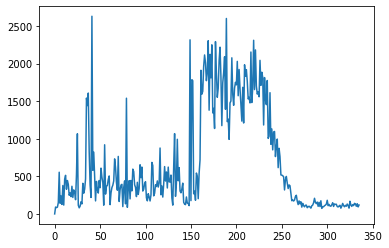

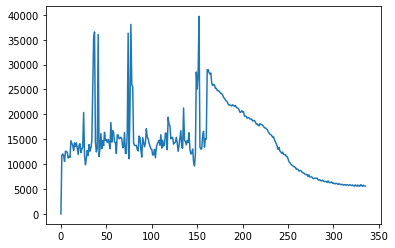

In [34]:
import time
start = time.time()
modelname = ['MTSSRP','Random','Oracle','TSSRP','AdaCUSUM']
# for i in range(nmodels):
for i in [0,2]:
    print(modelname[i])
    sequential_statistics_topRsum, sensor_selection_history, failure_mode_history, i,sequential_statistics= model_all[i].compute_monitoring_statistics(X.reshape((nt,nx*ny)),T0,-1)
    experiment_log['statistics'].append( sequential_statistics_topRsum)
    experiment_log['sens_history'].append(sensor_selection_history)
    experiment_log['mode_history'].append(failure_mode_history)
    experiment_log['seq_stats'].append(sequential_statistics)
    plt.figure()
    plt.plot(sequential_statistics_topRsum)
end = time.time()
print(end - start)

In [32]:
len(experiment_log['statistics'])

2